# Random Forest

After reading (Liu, V. et al.) and (Mahmoud, M. et al.) I decided to begin expirementing with random forest models instead of logistic regression models.

In other studies, random forest models were shown to out perform logisitc regression and support vector models likely due to the mix of tabular, categorical, and numerical features

## Read and prep data for modeling

In [93]:
import pandas as pd
import warnings
import numpy as np
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [53]:
df = pd.read_csv('../data/frame_no_interactions.csv', index_col=0)
df.head()


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,diag1_group_diabetes,diag1_group_digestive,diag1_group_genitourinary,diag1_group_injury,diag1_group_musculoskeletal,diag1_group_neoplasms,diag1_group_other,diag1_group_respiratory,diag2_group_circulatory,diag2_group_diabetes,diag2_group_digestive,diag2_group_genitourinary,diag2_group_injury,diag2_group_musculoskeletal,diag2_group_neoplasms,diag2_group_other,diag2_group_respiratory,diag3_group_circulatory,diag3_group_diabetes,diag3_group_digestive,diag3_group_genitourinary,diag3_group_injury,diag3_group_musculoskeletal,diag3_group_neoplasms,diag3_group_other,diag3_group_respiratory,admission_source_emergency,admission_source_refer,discharge_loc_other,specialty_cat_cardiology,specialty_cat_internal_medicine,specialty_cat_other,specialty_cat_pcp,specialty_cat_surgery,race_cat_african_american,race_cat_other,age_group_<30,age_group_>60,gender_female,a1c_group_high,a1c_group_normal,glucose_group_high,glucose_group_normal,admit_type_group_elective,admit_type_group_na,admit_type_group_urgent,diabetesMed_flag,change_flag,metformin_flag,insulin_flag,num_drugs,target
0,1,41,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,3,59,0,18,0,0,0,9,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0
2,2,11,5,13,2,0,1,6,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,2,44,1,16,0,0,0,7,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0
4,1,51,0,8,0,0,0,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,2,0


In [ ]:
# split initial train and test sections

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=0.2, stratify=df['target'])

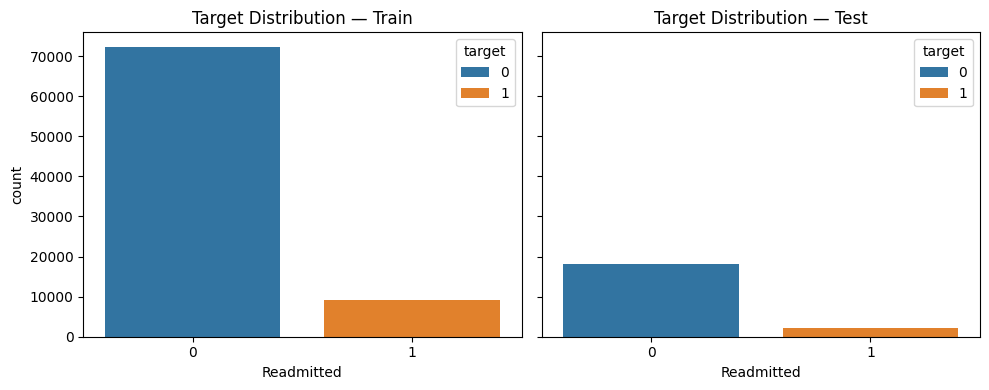

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

fix, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
sns.countplot(x=y_train, ax=axes[0], hue=y_train)
axes[0].set_title('Target Distribution — Train')
axes[0].set_xlabel('Readmitted')
axes[0].set_ylabel('count')

sns.countplot(x=y_test, ax=axes[1], hue=y_test)
axes[1].set_title('Target Distribution — Test')
axes[1].set_xlabel('Readmitted')
axes[1].set_ylabel('')


plt.tight_layout()
plt.show()


Reusable stratified k-fold builder

Use 10 folds as per work from Liu, V.

In [55]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
def make_cv():
    return StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=42
    )

Get a baseline before looking at feature importance or hyperparameter tuning

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler


cv = make_cv()

under_sample = RandomUnderSampler(random_state=42)
rf = RandomForestClassifier(random_state=42)

pipe = Pipeline([
    ('under_sample', under_sample),
    ('model', rf)
])

scores = cross_val_score(
    pipe, 
    X_train, 
    y_train, 
    cv = cv,
    scoring=make_scorer(roc_auc_score) 
    )

print('roc_auc score per fold: ', scores)
print('mean roc_auc score: ', scores.mean())

roc_auc score per fold:  [0.60293733 0.6017833  0.60320518 0.59561152 0.60185656 0.60307408
 0.59018928 0.60145133 0.59894777 0.59737224]
mean roc_auc score:  0.5996428593700658


The first run of random forest scores were abysmally poor running SMOTE:
 - mean roc_auc score:  0.5033108087188244

Swapping to RandomUnderSampler was somewhat better:
- mean roc_auc score:  0.5962262523855333

SMOTE performed much worse than under sampling so we will stick with under sampling going forward

In [57]:
# shared code
import matplotlib.pyplot as plt


def make_rf_pipe():
    _u = RandomUnderSampler(random_state=42)
    _rf = RandomForestClassifier(random_state=42)
    return Pipeline(
        [
            ('under_sample', _u),
            ('model', _rf)
        ]
    )

def plot_feature_importance(df, col1, col2, size, title):
    plt.figure(figsize=(10,6))
    plt.barh(df[col1][:size][::-1], df[col2][:size][::-1])
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()



In [58]:
# Build cv for feature and perumation importance

from sklearn.inspection import permutation_importance


def cv_feature_importance(pipe_factory, X, y, cv):
    """
    Fit the pipeline returned by pipe_factory() on each CV train fold,
    collect model.feature_importances_ and return mean/std per feature.
    """
    imps = []
    for train_idx, val_idx in cv.split(X,y):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        pipe = pipe_factory()
        pipe.fit(X_tr, y_tr)
        model = pipe.named_steps['model']
        imps.append(model.feature_importances_)
    imps = np.vstack(imps)
    df = pd.DataFrame({
        'feature' : X.columns,
        'importance_mean': imps.mean(axis=0),
        'importance_std' : imps.std(axis=0)
    }).sort_values('importance_mean', ascending=False)
    return df

def cv_permutation_importance(pipe_factory, X, y, cv, scoring='roc_auc', n_repeats=10, n_jobs=-1):
    """
    For each CV fold: fit on train, compute permutation_importance on validation.
    Aggregate mean/std across folds.
    """
    import numpy as np
    import pandas as pd

    perm_list = []
    for train_idx, val_idx in cv.split(X, y):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        pipe = pipe_factory()
        pipe.fit(X_tr, y_tr)
        r = permutation_importance(pipe, X_val, y_val, scoring=scoring, n_repeats=n_repeats, n_jobs=n_jobs, random_state=42)
        perm_list.append(r.importances_mean) #type: ignore
    perm_arr = np.vstack(perm_list)
    df = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': perm_arr.mean(axis=0),
        'importance_std': perm_arr.std(axis=0)
    }).sort_values('importance_mean', ascending=False)
    return df


### Feature Importance Using Random Forest Classifier

              feature  importance_mean  importance_std
1  num_lab_procedures         0.103559        0.000841
3     num_medications         0.091275        0.000427
0    time_in_hospital         0.066757        0.000408
6    number_inpatient         0.058055        0.001631
2      num_procedures         0.046189        0.000636


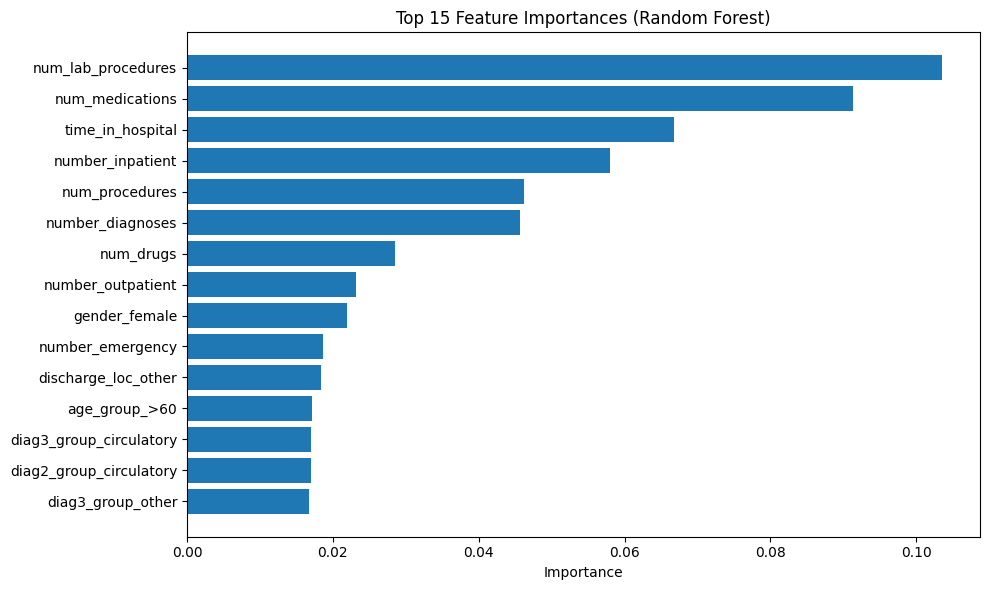

In [59]:
cv_rf = make_cv()

rf_imp_df = cv_feature_importance(make_rf_pipe, X_train, y_train, cv_rf)
print(rf_imp_df.head())
plot_feature_importance(rf_imp_df, 'feature', 'importance_mean', 15, "Top 15 Feature Importances (Random Forest)")

### Permutation Importance of Features

                     feature  importance_mean  importance_std
6           number_inpatient         0.060908        0.005787
36       discharge_loc_other         0.019771        0.003738
0           time_in_hospital         0.007016        0.002871
7           number_diagnoses         0.004672        0.002859
3            num_medications         0.003953        0.001902
5           number_emergency         0.003913        0.001990
1         num_lab_procedures         0.003019        0.003044
45             age_group_>60         0.002916        0.003270
2             num_procedures         0.002731        0.000902
15   diag1_group_respiratory         0.002113        0.001771
56            metformin_flag         0.001245        0.001314
8       diag1_group_diabetes         0.001208        0.000843
14         diag1_group_other         0.001155        0.001303
37  specialty_cat_cardiology         0.001120        0.001331
4          number_outpatient         0.001073        0.001643


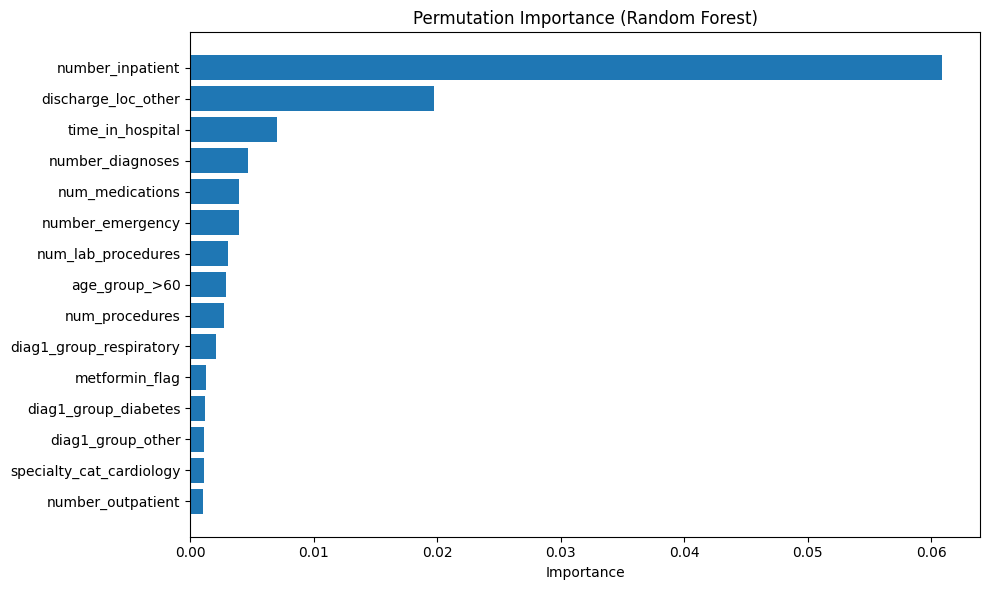

In [60]:
rf_perm_imp_df = cv_permutation_importance(make_rf_pipe, X_train, y_train, cv_rf)
print(rf_perm_imp_df.head(15))
plot_feature_importance(rf_perm_imp_df, 'feature', 'importance_mean', 15, 'Permutation Importance (Random Forest)')



Permutation importance reveals that the model is heavily leaning on the number of inpatient procedures for its predictions.


### Comparison of feature importance with different data sets

The above section shows feature importance plots for the data set without interaction terms

below I'll add the interaction terms. These were generated using methodology explained in the Data Preperation notebook

In [61]:
# get data with the interaction terms (linear data set)

df_int = pd.read_csv('../data/linear_frame.csv', index_col=0)

X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(df_int.drop(columns=['target']), df['target'], stratify=df['target'], random_state=42)







              feature  importance_mean  importance_std
1  num_lab_procedures         0.082923        0.000403
3     num_medications         0.073764        0.000424
6    number_inpatient         0.050704        0.001283
0    time_in_hospital         0.044150        0.000767
7    number_diagnoses         0.037916        0.000413


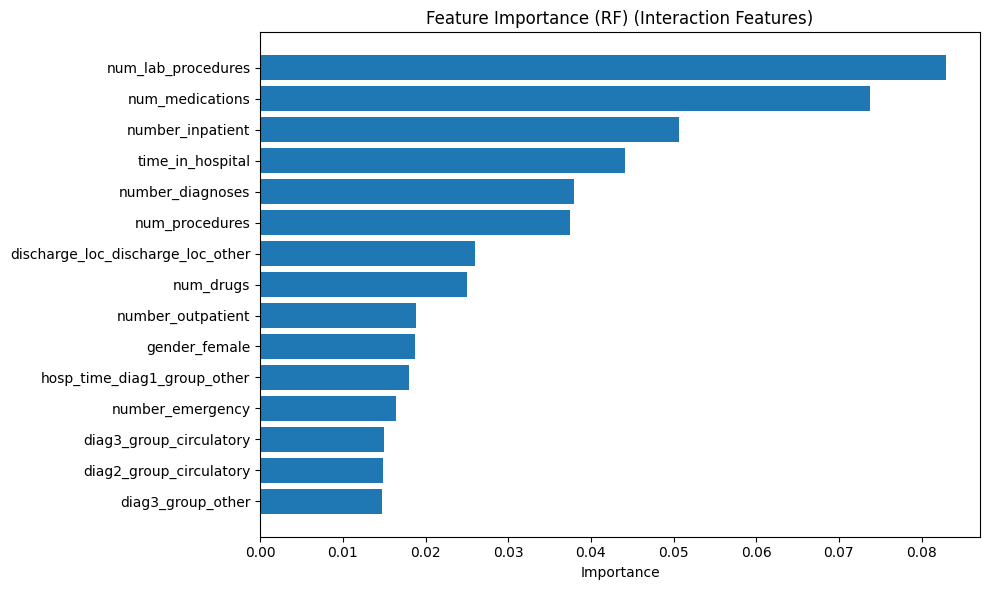

In [62]:
cv_rf_int = make_cv()

feat_imp_rf_int = cv_feature_importance(make_rf_pipe, X_train_int, y_train_int, cv_rf_int)

print(feat_imp_rf_int.head())
plot_feature_importance(feat_imp_rf_int, 'feature', 'importance_mean', 15, 'Feature Importance (RF) (Interaction Features)')

                              feature  importance_mean  importance_std
6                    number_inpatient         0.048930        0.006681
72  discharge_loc_discharge_loc_other         0.006080        0.002541
36                discharge_loc_other         0.004851        0.002467
5                    number_emergency         0.004127        0.001418
3                     num_medications         0.003027        0.002812


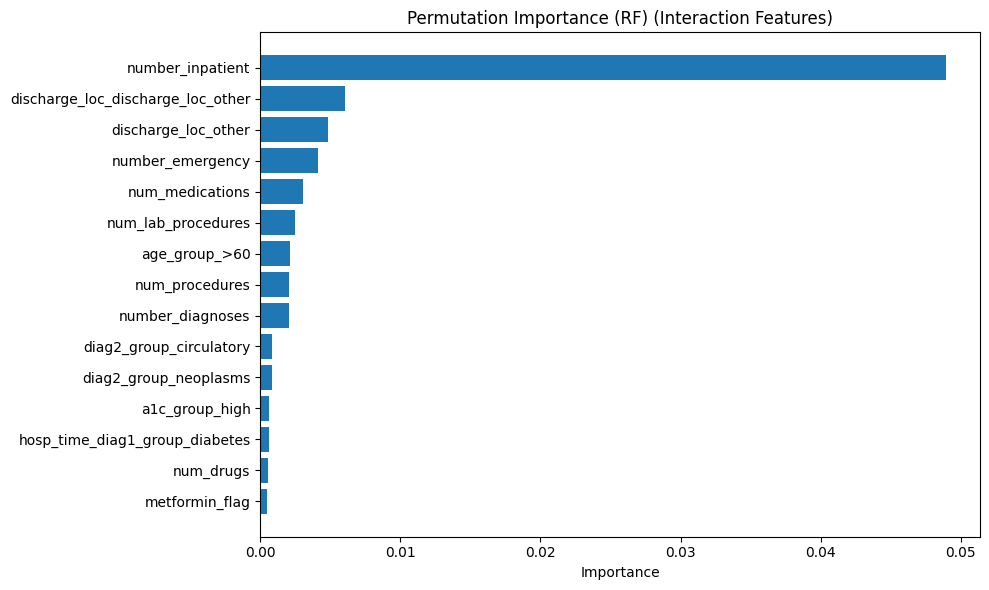

In [63]:
feat_perm_rt_int = cv_permutation_importance(make_rf_pipe, X_train_int, y_train_int, cv_rf_int)

print(feat_perm_rt_int.head())
plot_feature_importance(feat_perm_rt_int, 'feature', 'importance_mean', 15, 'Permutation Importance (RF) (Interaction Features)')

The above analysis leads me to believe I may have over simplified the discharge location (disposition) columns from the original data set as well as potentially losing information in the up/down signals from the medication groups. A more complex model might be needed to understand the different drug signals, but the work of *Monira, Mahmoud et al.* discusses dropping several of the drug columns due to lack of variance so more investigation into the drug data is required. 

For now, I will add a hyperparameter sweep using the random forest model to see if its performance can be increased.

### Hyperparameter Search for Random Forest



In [94]:
from sklearn.model_selection import RandomizedSearchCV


pipe_h = make_rf_pipe()

param_grid = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', 0.2, 0.5],
    'model__class_weight': [None, 'balanced'],
    'model__bootstrap': [True, False],
    'model__oob_score': [True, False]
}

rs = RandomizedSearchCV(
    estimator=pipe_h,
    param_distributions=param_grid,
    n_iter=30,
    scoring='roc_auc',
    cv=make_cv(),
    n_jobs=-1,
    random_state=42,
    refit=True
    )


rs.fit(X_train, y_train)

print("Best ROC AUC (cv):", rs.best_score_)
print("Best params:", rs.best_params_)

# Summarize top results
res_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
res_df[['rank_test_score','mean_test_score','std_test_score','params']].head(10)

Best ROC AUC (cv): 0.6539158011709406
Best params: {'model__oob_score': False, 'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': 0.2, 'model__max_depth': 10, 'model__class_weight': 'balanced', 'model__bootstrap': True}


,rank_test_score,mean_test_score,std_test_score,params
0,1,0.653916,0.008077,"{'model__oob_score': False, 'model__n_estimato..."
1,2,0.653790,0.008020,"{'model__oob_score': True, 'model__n_estimator..."
2,3,0.653704,0.007242,"{'model__oob_score': False, 'model__n_estimato..."
3,4,0.653599,0.007062,"{'model__oob_score': False, 'model__n_estimato..."
4,5,0.653486,0.007270,"{'model__oob_score': True, 'model__n_estimator..."
5,6,0.653156,0.008250,"{'model__oob_score': True, 'model__n_estimator..."
6,7,0.653135,0.005815,"{'model__oob_score': True, 'model__n_estimator..."
7,8,0.652803,0.006980,"{'model__oob_score': False, 'model__n_estimato..."
8,9,0.652082,0.007390,"{'model__oob_score': True, 'model__n_estimator..."
9,10,0.651739,0.007143,"{'model__oob_score': True, 'model__n_estimator..."


In [72]:
# predict on held out test set
y_proba = rs.best_estimator_.predict_proba(X_test)[:, 1] #type: ignore

In [91]:
from sklearn.metrics import (
    accuracy_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    classification_report
)

def print_metrics(y_true, y_pred):
    print("Accuracy:     ", accuracy_score(y_true, y_pred))
    print("F1 score:     ", f1_score(y_true, y_pred))
    print("Precision:    ", precision_score(y_true, y_pred))
    print("Recall:       ", recall_score(y_true, y_pred))
    print("\nConfusion matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification report:\n", classification_report(y_true, y_pred))


y_pred = rs.best_estimator_.predict(X_test) #type: ignore
# roc auc
print('Held Out Test Metrics (Random Forest)')
print('ROC AUC:', roc_auc_score(y_test, y_proba))
print_metrics(y_test, y_pred)



Held Out Test Metrics (Random Forest)
ROC AUC: 0.6515407816134953
Accuracy:      0.60041275612992
F1 score:      0.2611302925676903
Precision:     0.16451058958214082
Recall:        0.6327608982826949

Confusion matrix:
 [[10782  7298]
 [  834  1437]]

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.60      0.73     18080
           1       0.16      0.63      0.26      2271

    accuracy                           0.60     20351
   macro avg       0.55      0.61      0.49     20351
weighted avg       0.84      0.60      0.67     20351



The tuned random forest model initially displays decent class differentiation (ROC AUC = 0.65), but shows very poor Precision (0.16), and F1 (0.25) before threshold sweep.

The accuracy score is mostly meaningless due to high class imbalance.

The confusion matrix shows many false positives were predicted. 



Due to the nature of our business problem, we will align the model to attempt to maximize recall without sacrificing precision too much. This objective is due to the desire not to miss potential high risk patients while comparing the relatively low cost of having to spend extra time monitoring a patient who ends up without needing to be readmitted.

Best threshold (F2): 0.445
Precision: 0.146  Recall: 0.771  F2: 0.415


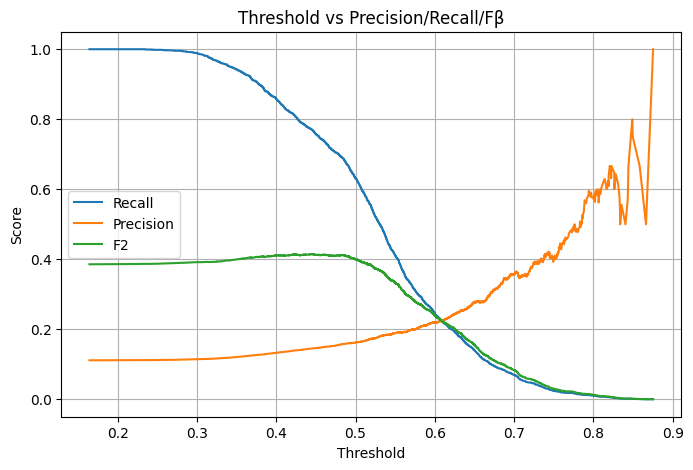

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# sweep thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# calculate F2 (recall-weighted) for each threshold
beta = 2
f2_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls + 1e-10)

# find threshold with best F2
best_idx = np.argmax(f2_scores)
best_thresh = thresholds[best_idx]
print(f"Best threshold (F{beta}): {best_thresh:.3f}")
print(f"Precision: {precisions[best_idx]:.3f}  Recall: {recalls[best_idx]:.3f}  F{beta}: {f2_scores[best_idx]:.3f}")

# plot everything
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, f2_scores[:-1], label=f"F{beta}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision/Recall/Fβ")
plt.legend()
plt.grid(True)
plt.show()

y_pred_custom = (y_proba >= best_thresh).astype(int)




In [92]:
print_metrics(y_test, y_pred_custom)

Accuracy:      0.4702471623016068
F1 score:      0.24518658545123573
Precision:     0.14577089577089578
Recall:        0.7710259797446058

Confusion matrix:
 [[ 7819 10261]
 [  520  1751]]

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.43      0.59     18080
           1       0.15      0.77      0.25      2271

    accuracy                           0.47     20351
   macro avg       0.54      0.60      0.42     20351
weighted avg       0.85      0.47      0.55     20351



By tuning the threshold we raised positive class recall to 0.77 while maintaining a 0.15 precision (low but almost unchanged from previous test)